In [1]:
import os, math, numpy as np, pandas as pd
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, GCNConv



In [2]:
import sys, torch

print("exe:", sys.executable)
print("torch:", torch.__version__)
print("cuda build:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

exe: C:\Users\Alice\PycharmProjects\co-simulation-code\.venv1\Scripts\python.exe
torch: 2.5.1+cu121
cuda build: 12.1
cuda available: True
gpu: NVIDIA GeForce RTX 4070 Laptop GPU


In [3]:
import sys, os, torch, site, pkgutil, importlib
print("exe:", sys.executable)
print("torch version:", torch.__version__)
print("torch file:", torch.__file__)
print("PYTORCH_FORCE_CPU:", os.environ.get("PYTORCH_FORCE_CPU"))
print("site-packages:", site.getsitepackages())
print("user site:", site.getusersitepackages())
#print(sys.path)  # uncomment if needed


exe: C:\Users\Alice\PycharmProjects\co-simulation-code\.venv1\Scripts\python.exe
torch version: 2.5.1+cu121
torch file: C:\Users\Alice\PycharmProjects\co-simulation-code\.venv1\Lib\site-packages\torch\__init__.py
PYTORCH_FORCE_CPU: None
site-packages: ['C:\\Users\\Alice\\PycharmProjects\\co-simulation-code\\.venv1', 'C:\\Users\\Alice\\PycharmProjects\\co-simulation-code\\.venv1\\Lib\\site-packages']
user site: C:\Users\Alice\AppData\Roaming\Python\Python311\site-packages


In [4]:
import sys; print(sys.version)


3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


In [4]:
data = pd.read_parquet("final_dataset.parquet")

In [5]:
data.columns

Index(['Timestamp', 'Src IP', 'Dst IP', 'Bwd Packet Length Min', 'Protocol_6',
       'Bwd Packets/s', 'FWD Init Win Bytes', 'Packet Length Std',
       'FIN Flag Count', 'SrcPortRange_registered', 'Packet Length Min',
       'Fwd Seg Size Min', 'DstPortRange_well_known', 'Bwd IAT Total',
       'SYN Flag Count', 'Bwd Packet Length Std', 'target'],
      dtype='object')

In [6]:
# Your edge feature columns (adjust if you want more/less)
EDGE_COLS = [
    'Bwd Packet Length Min', 'Protocol_6', 'Bwd Packets/s', 'FWD Init Win Bytes',
    'Packet Length Std', 'FIN Flag Count', 'SrcPortRange_registered',
    'Packet Length Min', 'Fwd Seg Size Min', 'DstPortRange_well_known',
    'Bwd IAT Total', 'SYN Flag Count', 'Bwd Packet Length Std'
]
ID_COLS = ['Src IP','Dst IP','Timestamp']
LABEL_COL = 'target'   # binary {0,1}

# Time encoding (periods in seconds)
def time_posenc(t, periods=(60, 300, 3600)):
    # t: numpy array of epoch seconds
    feats = []
    for P in periods:
        w = 2*math.pi/P
        feats.append(np.sin(w*t))
        feats.append(np.cos(w*t))
    return np.stack(feats, axis=1)  # [N, 2*len(periods)]

In [7]:
from sklearn.preprocessing import StandardScaler


def bin_time(df, bin_seconds=300):
    # Expect df['Timestamp'] as datetime or string; convert to seconds
    ts = pd.to_datetime(df['Timestamp'], errors='coerce', utc=True).astype('int64') // 10**9
    df = df.copy()
    df['_epoch'] = ts
    df['_bin'] = (ts // bin_seconds).astype(int)
    return df

def build_snapshots(df, scaler_edge=None, fit_scaler=False, bin_seconds=300, device='cpu'):
    """
    Returns:
      snapshots: list[Data] in time order
      ip2idx: dict mapping IP -> node index (per full dataset, stable across train/test)
      scaler_edge: fitted StandardScaler for edge features
      edge_cols_kept: list of columns used (existing + non-NA)
    """
    # Keep only available columns
    edge_cols = [c for c in EDGE_COLS if c in df.columns]
    cols_needed = ID_COLS + edge_cols + [LABEL_COL]
    cols_needed = [c for c in cols_needed if c in df.columns]
    df = df[cols_needed].dropna(subset=['Src IP','Dst IP'])
    df = bin_time(df, bin_seconds=bin_seconds)

    # Edge feature scaler
    if scaler_edge is None:
        scaler_edge = StandardScaler()
        fit_scaler = True
    if fit_scaler:
        scaler_edge.fit(df[edge_cols].astype(float).values)

    # Stable node indexing across all snapshots in this split
    ips = pd.Index(pd.unique(pd.concat([df['Src IP'], df['Dst IP']])))
    ip2idx = {ip:i for i,ip in enumerate(ips)}

    snapshots = []
    # For 1-bin lag activity: track per-node edge count in previous bin
    prev_activity = defaultdict(int)

    for b, g in df.sort_values('_bin').groupby('_bin'):
        # Map nodes
        src = g['Src IP'].map(ip2idx).astype(int).values
        dst = g['Dst IP'].map(ip2idx).astype(int).values
        edge_index = torch.tensor(np.vstack([src, dst]), dtype=torch.long)

        # Edge attributes = scaled flow features + time encoding
        eX = scaler_edge.transform(g[edge_cols].astype(float).values)
        tfe = time_posenc(g['_epoch'].values)  # [E, 2*len(periods)]
        edge_attr = torch.tensor(np.hstack([eX, tfe]), dtype=torch.float)

        # Labels (edge-level)
        y = torch.tensor(g[LABEL_COL].astype(int).values, dtype=torch.long)

        # Node features (inductive, not learned):
        #   in/out/total degree in THIS snapshot + previous-bin activity count
        n_nodes = len(ip2idx)
        out_deg = np.bincount(src, minlength=n_nodes)
        in_deg  = np.bincount(dst, minlength=n_nodes)
        deg     = (out_deg + in_deg).reshape(-1,1)
        node_feat = np.hstack([
            in_deg.reshape(-1,1),
            out_deg.reshape(-1,1),
            deg,
            np.array([prev_activity[i] for i in range(n_nodes)]).reshape(-1,1)
        ])
        # log1p to compress scale
        node_feat = np.log1p(node_feat)
        x = torch.tensor(node_feat, dtype=torch.float)

        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y
        )
        # Store mapping to recover edge order if needed
        data._bin = int(b)
        snapshots.append(data)

        # Update prev_activity for next bin (count edges touched by node this bin)
        touched = np.bincount(np.concatenate([src, dst]), minlength=n_nodes)
        for i, c in enumerate(touched):
            prev_activity[i] = int(c)

    # Move to device lazily in loader/training
    return snapshots, ip2idx, scaler_edge, edge_cols + [f'time_{i}' for i in range(tfe.shape[1])]

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv, LayerNorm

class GraphTimeEdgeClassifier(nn.Module):
    def __init__(self, in_node, in_edge, hidden=64, gnn='sage',
                 num_layers=2, dropout=0.2, gat_heads=4,
                 use_edge_attr_in_gat=True, pair_mode='concat'):
        """
        gnn: 'gcn' | 'sage' | 'gat'
        pair_mode: 'concat' (h_i || h_j), 'concat+diff+had' (richer), or 'had' (h_i * h_j)
        """
        super().__init__()
        self.gnn = gnn
        self.dropout = nn.Dropout(dropout)
        self.pair_mode = pair_mode
        self.hidden = hidden
        self.in_edge = in_edge
        self.gat_heads = gat_heads
        self.use_edge_attr_in_gat = use_edge_attr_in_gat

        # --- conv factory
        def make_conv(i, o):
            if gnn == 'gcn':
                return GCNConv(i, o, normalize=True)
            elif gnn == 'sage':
                return SAGEConv(i, o)
            elif gnn == 'gat':
                # keep output dim = hidden by concatenating heads
                out_per_head = o // gat_heads
                assert o % gat_heads == 0, "hidden must be divisible by gat_heads"
                return GATv2Conv(
                    in_channels=i,
                    out_channels=out_per_head,
                    heads=gat_heads,
                    concat=True,
                    edge_dim=(in_edge if use_edge_attr_in_gat else None)
                )
            else:
                raise ValueError("gnn must be 'gcn', 'sage', or 'gat'")

        # --- layers
        dims = [in_node] + [hidden] * num_layers
        self.convs = nn.ModuleList([make_conv(dims[i], dims[i+1]) for i in range(num_layers)])
        self.norms = nn.ModuleList([LayerNorm(hidden) for _ in range(num_layers)])

        # --- edge head input dim based on pairing
        if pair_mode == 'concat':
            edge_in = 2*hidden + in_edge
        elif pair_mode == 'concat+diff+had':
            edge_in = (2*hidden + hidden + hidden) + in_edge  # h_i||h_j||(h_i-h_j)||(h_i*h_j)
        elif pair_mode == 'had':
            edge_in = hidden + in_edge                        # (h_i*h_j)||edge_attr
        else:
            raise ValueError("pair_mode not recognized")

        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_in, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)
        )

    def node_encode(self, x, edge_index, edge_attr):
        for l, conv in enumerate(self.convs):
            h_in = x
            if self.gnn == 'gat':
                x = conv(x, edge_index, edge_attr=edge_attr if self.use_edge_attr_in_gat else None)
            else:
                x = conv(x, edge_index)
            x = self.norms[l](x)
            x = F.relu(x)
            x = self.dropout(x)
            # simple residual if dims match
            if h_in.shape == x.shape:
                x = x + h_in
        return x  # [N, hidden]

    def pair_edges(self, x, edge_index, edge_attr):
        src, dst = edge_index
        h_i, h_j = x[src], x[dst]          # [E, hidden], [E, hidden]
        if self.pair_mode == 'concat':
            z = torch.cat([h_i, h_j, edge_attr], dim=1)
        elif self.pair_mode == 'concat+diff+had':
            z = torch.cat([h_i, h_j, h_i - h_j, h_i * h_j, edge_attr], dim=1)
        else:  # 'had'
            z = torch.cat([h_i * h_j, edge_attr], dim=1)
        return z

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.node_encode(x, edge_index, edge_attr)          # [N, hidden]
        z = self.pair_edges(x, edge_index, edge_attr)           # [E, ...]
        logits = self.edge_mlp(z)                               # [E, 2]
        return logits


In [9]:
def run_epoch(model, snapshots, optimizer=None, device='cpu', weights=None):
    is_train = optimizer is not None
    total_loss, total_correct, total_edges = 0.0, 0, 0
    ce = nn.CrossEntropyLoss(weight=weights)   # <--- use weights

    for data in snapshots:
        data = data.to(device)
        logits = model(data)
        if is_train:
            loss = ce(logits, data.y)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += float(loss.item()) * data.y.numel()
        with torch.no_grad():
            pred = logits.argmax(dim=1)
            total_correct += int((pred == data.y).sum())
            total_edges += int(data.y.numel())

    avg_loss = total_loss / max(1, total_edges) if is_train else None
    acc = total_correct / max(1, total_edges)
    return avg_loss, acc


In [10]:
tmp = bin_time(data, bin_seconds=300).sort_values('_bin')
bins = tmp['_bin'].unique()
n = len(bins)
b_train = bins[:int(0.7*n)]
b_val   = bins[int(0.7*n):int(0.85*n)]
b_test  = bins[int(0.85*n):]

train_df = tmp[tmp['_bin'].isin(b_train)].drop(columns=['_bin','_epoch'])
val_df   = tmp[tmp['_bin'].isin(b_val)].drop(columns=['_bin','_epoch'])
test_df  = tmp[tmp['_bin'].isin(b_test)].drop(columns=['_bin','_epoch'])


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [14]:

import torch
print("torch:", torch.__version__)
print("cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())


torch: 2.5.1+cu121
cuda: 12.1
cuda available: True


In [15]:
# Assume you already have train_df and test_df with the listed columns
# Build train snapshots (fit scaler)
train_snaps, train_ip2idx, scaler_edge, edge_cols_used = build_snapshots(
    train_df, scaler_edge=None, fit_scaler=True, bin_seconds=300, device=device
)

# Build test snapshots (reuse scaler; allow different IP set)
# To preserve strict inductive setting, we build a separate ip2idx for test (no shared node IDs).
test_snaps, test_ip2idx, _, _ = build_snapshots(
    test_df, scaler_edge=scaler_edge, fit_scaler=False, bin_seconds=300, device=device
)


# Build val with the same scaler (no fitting here)
val_snaps,   val_ip2idx,   _, _ = build_snapshots(
    val_df, scaler_edge=scaler_edge, fit_scaler=False, bin_seconds=300
)


In [15]:
# Model dims
in_node = train_snaps[0].x.size(1)             # [in_deg, out_deg, deg, prev_activity] -> 4
in_edge = train_snaps[0].edge_attr.size(1)     # len(EDGE_COLS_kept) + time_posenc
model = GraphTimeEdgeClassifier(in_node=in_node, in_edge=in_edge,
                                hidden=32, gnn='gat', num_layers=2, dropout=0.2).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 5
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_snaps, optimizer=opt, device=device)
    _, te_acc = run_epoch(model, test_snaps, optimizer=None, device=device)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} | train acc {tr_acc:.4f} | test acc {te_acc:.4f}")


Epoch 01 | train loss 0.7376 | train acc 0.8515 | test acc 1.0000
Epoch 02 | train loss 0.2425 | train acc 0.8884 | test acc 0.9974
Epoch 03 | train loss 0.0416 | train acc 0.9831 | test acc 0.9970
Epoch 04 | train loss 0.0285 | train acc 0.9821 | test acc 0.9985
Epoch 05 | train loss 0.0031 | train acc 0.9995 | test acc 0.9996


In [18]:
# ---------- SAFE SETTINGS (put first) ----------
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["KMP_AFFINITY"] = "disabled"
os.environ["KMP_BLOCKTIME"] = "0"

import torch
torch.set_num_threads(4)
torch.set_num_interop_threads(1)
try:
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ---------- HELPERS ----------
import numpy as np
from sklearn.metrics import average_precision_score, roc_auc_score

def has_both_classes(d):
    y = d.y
    return bool((y == 0).any() and (y == 1).any())

def sample_edges_stratified(data, pos_frac=1.0, neg_frac=0.5, max_edges=None):
    """Keep all positives (or a fraction) and subsample negatives -> preserves class balance."""
    import torch
    y = data.y
    pos_idx = torch.nonzero(y == 1, as_tuple=False).view(-1)
    neg_idx = torch.nonzero(y == 0, as_tuple=False).view(-1)

    if len(pos_idx) == 0 and len(neg_idx) == 0:
        return data

    k_pos = len(pos_idx) if pos_frac >= 1 else max(1, int(len(pos_idx) * pos_frac)) if len(pos_idx) > 0 else 0
    k_neg = len(neg_idx) if neg_frac >= 1 else max(1, int(len(neg_idx) * neg_frac)) if len(neg_idx) > 0 else 0

    pos_keep = pos_idx[torch.randperm(len(pos_idx))[:k_pos]] if len(pos_idx) > 0 else pos_idx
    neg_keep = neg_idx[torch.randperm(len(neg_idx))[:k_neg]] if len(neg_idx) > 0 else neg_idx

    keep = torch.cat([pos_keep, neg_keep])
    if keep.numel() == 0:
        return data
    if max_edges is not None and keep.numel() > max_edges:
        keep = keep[torch.randperm(keep.numel())[:max_edges]]

    d = data.clone()
    d.edge_index = d.edge_index[:, keep]
    d.edge_attr  = d.edge_attr[keep]
    d.y          = d.y[keep]
    return d

def class_weights_from_snaps(snaps, device):
    neg = pos = 0
    for d in snaps:
        y = d.y
        neg += int((y == 0).sum())
        pos += int((y == 1).sum())
    w1 = (neg / max(1, pos)) if pos > 0 else 1.0
    return torch.tensor([1.0, w1], device=device, dtype=torch.float32)

@torch.no_grad()
def eval_pr_auc(model, snaps, device):
    """Skips single-class snapshots to avoid undefined metrics."""
    model.eval()
    ys, ps = [], []
    for d in snaps:
        if not has_both_classes(d):
            continue
        d = d.to(device)
        logits = model(d)                         # [E, 2]
        ps.append(torch.softmax(logits, 1)[:, 1].detach().cpu().numpy())
        ys.append(d.y.cpu().numpy())
    if not ys:
        return float("nan"), float("nan")
    y = np.concatenate(ys); p = np.concatenate(ps)
    return average_precision_score(y, p), roc_auc_score(y, p)

def train_one(model, snaps, snaps_val, device,
              lr=1e-3, wd=1e-5, epochs=10, patience=2, weights=None):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    ce  = torch.nn.CrossEntropyLoss(weight=weights)
    best, best_state, wait = -1.0, None, 0
    for ep in range(1, epochs + 1):
        model.train()
        for d in snaps:
            d = d.to(device, non_blocking=True)
            logits = model(d)
            loss = ce(logits, d.y)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            opt.step()
        pr, _ = eval_pr_auc(model, snaps_val, device)
        if pr > best:
            best, best_state, wait = pr, {k: v.detach().cpu() for k, v in model.state_dict().items()}, 0
        else:
            wait += 1
            if wait >= patience:
                break
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return best

# ---------- TUNING DATA (light, balanced) ----------
# Keep all positives, 50% negatives; drop single-class; cap counts for stability
tune_train_snaps = [sample_edges_stratified(d, pos_frac=1.0, neg_frac=0.5, max_edges=20000) for d in train_snaps]
tune_val_snaps   = [sample_edges_stratified(d, pos_frac=1.0, neg_frac=0.5, max_edges=20000) for d in val_snaps]
tune_train_snaps = [d for d in tune_train_snaps if has_both_classes(d)][:30]
tune_val_snaps   = [d for d in tune_val_snaps   if has_both_classes(d)][:12]

# ---------- SEARCH SPACE (includes GAT) ----------
import random
search = {
    "gnn": ["sage", "gcn", "gat"],
    "hidden": [32, 64, 128],
    "num_layers": [2],
    "dropout": [0.1, 0.2],
    "lr": [5e-4, 1e-3],
    "weight_decay": [0.0, 1e-5],
    "pair_mode": ["concat"],
    "gat_heads": [2, 4],   # used only if gnn='gat'
}

def sample_cfg():
    cfg = {k: random.choice(v) for k, v in search.items()}
    if cfg["gnn"] != "gat":
        cfg["gat_heads"] = 2
    # enforce divisibility for GAT
    if cfg["gnn"] == "gat" and (cfg["hidden"] % cfg["gat_heads"] != 0):
        cfg["gat_heads"] = 2
    return cfg

# ---------- RUN TUNING ----------
in_node = train_snaps[0].x.size(1)
in_edge = train_snaps[0].edge_attr.size(1)
weights = class_weights_from_snaps(train_snaps, device)

best_cfg, best_score, best_model = None, -1.0, None
N_TRIALS = 20  # raise later once stable

for trial in range(N_TRIALS):
    cfg = sample_cfg()
    try:
        model = GraphTimeEdgeClassifier(
            in_node=in_node, in_edge=in_edge,
            hidden=cfg["hidden"], gnn=cfg["gnn"],
            num_layers=cfg["num_layers"], dropout=cfg["dropout"],
            gat_heads=cfg["gat_heads"], use_edge_attr_in_gat=True,
            pair_mode=cfg["pair_mode"]
        ).to(device)

        score = train_one(model, tune_train_snaps, tune_val_snaps, device,
                          lr=cfg["lr"], wd=cfg["weight_decay"],
                          epochs=10, patience=2, weights=weights)
        print(f"trial {trial:02d} | cfg={cfg} | val PR-AUC={score:.4f}")
        if score > best_score:
            best_cfg, best_score, best_model = cfg, score, model
    except torch.cuda.OutOfMemoryError:
        print(f"trial {trial:02d} OOM -> skipped")
    finally:
        if device == "cuda":
            torch.cuda.synchronize()
            torch.cuda.empty_cache()

print("\nBEST:", best_cfg, "PR-AUC:", best_score)

# ---------- RETRAIN BEST ON TRAIN+VAL, THEN TEST ----------
tv_snaps = train_snaps + val_snaps
best_model = GraphTimeEdgeClassifier(
    in_node=in_node, in_edge=in_edge,
    hidden=best_cfg["hidden"], gnn=best_cfg["gnn"],
    num_layers=best_cfg["num_layers"], dropout=best_cfg["dropout"],
    gat_heads=best_cfg.get("gat_heads", 2), use_edge_attr_in_gat=True,
    pair_mode=best_cfg["pair_mode"]
).to(device)

_ = train_one(best_model, tv_snaps, val_snaps, device,
              lr=best_cfg["lr"], wd=best_cfg["weight_decay"],
              epochs=15, patience=3, weights=weights)

test_pr, test_roc = eval_pr_auc(best_model, test_snaps, device)
print("TEST  PR-AUC:", test_pr, "ROC-AUC:", test_roc)


device: cuda
trial 00 | cfg={'gnn': 'gat', 'hidden': 128, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 0.0, 'pair_mode': 'concat', 'gat_heads': 2} | val PR-AUC=0.0005
trial 01 | cfg={'gnn': 'gat', 'hidden': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 1e-05, 'pair_mode': 'concat', 'gat_heads': 2} | val PR-AUC=0.0005
trial 02 | cfg={'gnn': 'gat', 'hidden': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 1e-05, 'pair_mode': 'concat', 'gat_heads': 2} | val PR-AUC=0.0060
trial 03 | cfg={'gnn': 'sage', 'hidden': 128, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 0.0, 'pair_mode': 'concat', 'gat_heads': 2} | val PR-AUC=0.0018
trial 04 | cfg={'gnn': 'gat', 'hidden': 32, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.001, 'weight_decay': 1e-05, 'pair_mode': 'concat', 'gat_heads': 2} | val PR-AUC=0.0027
trial 05 | cfg={'gnn': 'sage', 'hidden': 64, 'num_layers': 2, 'dropout': 0.2, 'lr': 0.0005, 'weight_decay': 1e-05, 'pair_mode

In [26]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import torch

@torch.no_grad()
def pick_threshold_by_f1(model, snaps, device):
    model.eval()
    ys, ps = [], []
    for d in snaps:
        if not has_both_classes(d):
            continue
        d = d.to(device)
        logits = model(d)
        p1 = torch.softmax(logits,1)[:,1].cpu().numpy()
        ys.append(d.y.cpu().numpy())
        ps.append(p1)
    if not ys:
        return 0.5
    y = np.concatenate(ys); p = np.concatenate(ps)
    precision, recall, thresholds = precision_recall_curve(y, p)
    f1 = 2*precision*recall / (precision+recall+1e-12)
    if thresholds.size == 0:
        return 0.5
    return float(thresholds[np.nanargmax(f1)])


In [27]:
# === Best config you decided to use ===
best_cfg = {
    "gnn": "sage",          # e.g. "gat" (or "sage"/"gcn")
    "hidden": 64,          # put your best here
    "num_layers": 2,
    "dropout": 0.2,
    "gat_heads": 4,        # ONLY used for GAT; hidden must be divisible by gat_heads
    "pair_mode": "concat", # same as you used during tuning
    "lr": 0.001,
    "weight_decay": 1e-05,
}

# === Model dims ===
in_node = train_snaps[0].x.size(1)
in_edge = train_snaps[0].edge_attr.size(1)
# weights from training snaps
weights = class_weights_from_snaps(train_snaps, device)

model = GraphTimeEdgeClassifier(
    in_node=in_node, in_edge=in_edge,
    hidden=best_cfg["hidden"], gnn=best_cfg["gnn"],
    num_layers=best_cfg["num_layers"], dropout=best_cfg["dropout"],
    gat_heads=best_cfg.get("gat_heads", 2),
    use_edge_attr_in_gat=True, pair_mode=best_cfg.get("pair_mode", "concat"),
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=best_cfg["lr"], weight_decay=best_cfg["weight_decay"])

EPOCHS = 5
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_snaps, optimizer=opt, device=device, weights=weights)
    _, te_acc = run_epoch(model, test_snaps, optimizer=None, device=device, weights=weights)
    pr, roc = eval_pr_auc(model, val_snaps, device)
    print(f"Epoch {epoch:02d} | loss {tr_loss:.4f} | acc {tr_acc:.4f} | val PR-AUC {pr:.6f} | val ROC-AUC {roc:.6f}")

# choose threshold on validation
th = pick_threshold_by_f1(model, val_snaps, device)
print("Chosen threshold:", th)

# final test metrics
test_pr, test_roc = eval_pr_auc(model, test_snaps, device)
print("TEST PR-AUC:", test_pr, "ROC-AUC:", test_roc)



Epoch 01 | loss 1.9390 | acc 0.8492 | val PR-AUC 0.030795 | val ROC-AUC 0.990847
Epoch 02 | loss 0.2100 | acc 0.9677 | val PR-AUC 0.012141 | val ROC-AUC 0.989456
Epoch 03 | loss 0.0096 | acc 0.9984 | val PR-AUC 0.024246 | val ROC-AUC 0.996525
Epoch 04 | loss 0.0039 | acc 0.9995 | val PR-AUC 0.024285 | val ROC-AUC 0.995645
Epoch 05 | loss 0.0028 | acc 0.9996 | val PR-AUC 0.031492 | val ROC-AUC 0.996238
Chosen threshold: 0.009771013632416725
TEST PR-AUC: 0.005942947973831542 ROC-AUC: 0.9861902518096244


In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

@torch.no_grad()
def evaluate_with_confusion_threshold(model, snapshots, device='cpu', thresh=0.5,
                                      title='Confusion Matrix (Test Set)'):
    model.eval()
    all_p = []
    all_y = []
    for data in snapshots:
        data = data.to(device)
        p1 = torch.softmax(model(data), 1)[:, 1].cpu().numpy()
        y  = data.y.cpu().numpy()
        all_p.append(p1); all_y.append(y)

    y = np.concatenate(all_y)
    p = np.concatenate(all_p)
    pred = (p >= thresh).astype(int)

    # Force 2x2 matrix even if a class is missing
    cm = confusion_matrix(y, pred, labels=[0, 1])

    # Plot (counts and normalized)
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'],
                ax=axs[0]); axs[0].set_title(title); axs[0].set_xlabel('Predicted'); axs[0].set_ylabel('True')

    cm_norm = cm / cm.sum(axis=1, keepdims=True).clip(min=1)
    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'],
                ax=axs[1]); axs[1].set_title('Row-normalized'); axs[1].set_xlabel('Predicted'); axs[1].set_ylabel('True')
    plt.tight_layout(); plt.show()

    # Robust report (avoid divide-by-zero warnings)
    report = classification_report(y, pred, labels=[0,1], digits=4, zero_division=0)
    print("📊 Classification Report:")
    print(report)

    return cm, report, {'threshold': thresh, 'pos_rate_pred': float(pred.mean()), 'pos_rate_true': float(y.mean())}


Chosen threshold: 0.009771013632416725


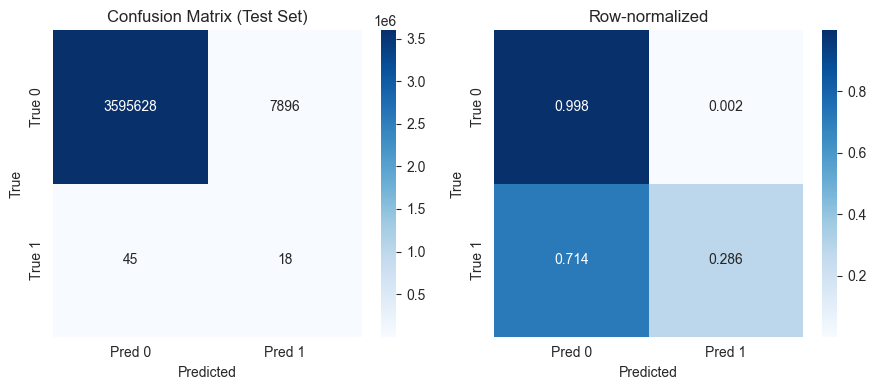

📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9978    0.9989   3603524
           1     0.0023    0.2857    0.0045        63

    accuracy                         0.9978   3603587
   macro avg     0.5011    0.6418    0.5017   3603587
weighted avg     1.0000    0.9978    0.9989   3603587

Extra info: {'threshold': 0.009771013632416725, 'pos_rate_pred': 0.0021961451187386344, 'pos_rate_true': 1.748258055098989e-05}


In [31]:
# Choose threshold on validation set
th = pick_threshold_by_f1(model, val_snaps, device)
print("Chosen threshold:", th)

# Evaluate on test with that threshold
cm, report, info = evaluate_with_confusion_threshold(model, test_snaps, device=device, thresh=th)
print("Extra info:", info)
